# Healthcare Fraud Detection
Author: Shanrong Zhou

Roughly one-third of the $3.3T spent on healthcare in the US is attributable to fraud, waste, and abuse. The US Medicare system is particularly susceptible fraud and abuse, since it is harder to exclude problematic providers and is managed separately and with limited coordination across the states. In recent years, machine learning and data mining techniques are being used to address this problem.
- Objectives: This report uses a real dataset to conduct healthcare fraud/abuse detection. Previously, I've finished the Feature Engineering and created new features in the previous project, <a href="attachment_Assignment4_Feature%20Engineering%20(FE)%20&%20Exploratory%20Data%20Analysis%20(EDA)%20for%20Healthcare%20Fraud%20Detection.html">Feature Engineering (FE) & Exploratory Data Analysis (EDA) for Healthcare Fraud Detection</a>. In this project, I will use unsupervised learning methods (PCA and KNNs) to revise the features and identify anomalous hospitals that may abuse/defraud healthcare resources. 
- Dataset: The Medicare Inpatient Hospitals by Geography and Service dataset provides information on hospital discharges for Original Medicare Part A beneficiaries by IPPS hospitals. This dataset contains information on the number of discharges, payments, and submitted charges organized by geography and Medicare Severity Diagnosis Related Group (DRG). 

# Table of Contents
- [Section 1 Data Preparation](#1)
  - [1.1 Understanding Data](#11)
  - [1.2 Data Splitting](#12)
  - [1.3 Exploratory Data Analysis (EDA)](#13)
  - [1.4 Feature Selection](#14)
- [Section 2 Principal Component Analysis (PCA)](#2)
  - [2.1 Build the model](#21)
  - [2.2 Determine the threshold](#22)
  - [2.3 Descriptive statistics of the normal and outlier groups](#23)
- [Section 3 K-nearest neighbor algorithm (KNNs)](#3)
  - [3.1 Build the model](#31)
  - [3.2 Determine the threshold](#32)
  - [3.3 Descriptive statistics of the normal and outlier groups](#33)
  - [3.4 Model Iteration](#34)
  - [3.5 Achieve model stability by aggregating multiple models](#35)
- [Section 4 Conclusion](#4)
  - [4.1 Outliers Identified by Multiple Models](#41)
  - [4.2 Explain the Outlier Score of an Observation](#42)

## Section 1 Data Preparation <a class="anchor" id="1"></a>

###  1.1 Understanding Data<a class="anchor" id="11"></a>

Basic business understandings of the raw data:
- Each row is a hospital and it's DRG. The hospital is the healthcare service provider in the Medicare environment. Each of the hospital can serve multiple DRGs.
- Here are business interpretation of some data fields, which will help us for better understand the context and analyse the data insights later.
    - DRG Definition: Diagnosis Related Group is the classification system that groups similar clinical conditions (diagnoses) and the procedures furnished by the hospital during the stay.
    - Hospital Referral Region Description: It is a geographical categorization used to define specific areas in the United States that have similar patterns of healthcare resource use. These regions are defined by the Centers for Medicare and Medicaid Services (CMS) to analyze and compare healthcare utilization and costs across different locations.
    - Total Discharges: The number (count) of discharges billed by the provider for inpatient hospital services. It indicates the count of individuals who were admitted to and subsequently released from the provider's care.
    - Average Covered Charges: The average amount charged by the healthcare provider for services rendered to patients. It represents the cost of medical procedures and treatments that are typically covered by health insurance plans.
    - Average Total Payments (Total Payments / Total Discharges): The average payment received by the healthcare provider for services provided to patients. It includes payments made by insurance companies, patients, and other third-party payers.
    - Average Medicare Payment (Medicare Payment Amount / Total Discharges): The average payment made by the Medicare program to the healthcare provider for services rendered to Medicare beneficiaries. It specifically refers to the payments made by the government-funded Medicare insurance program.
    - Medicare Reimburse Rate (Average Medicare Payment /Average Total Payments): The average Medicare reimbursement rate, which is the proportion of payment that Medicare program covers in the total payment.

The new features (last 12 variables) are created with benchmarking. There are 3 steps for creating each new feature:
1. Group hospitals the by diagnosis (DRG) and geographical (state, city, or hospital referral region) categorization.
2. Calculate the average or median of the defined hospital group's Medicare payment amount or reimbursement rate as the benchmark for single hospital comparison. 
3. Create new feature to reflect the comparison directly (eg. ratio of each hospital to the average or median of the defined hospital group). 

This method tells the hospital reimbursement pattern of a defined hospital group. By selecting the hospitals that deviated a lot from the benchmark, we can define them as anomalies for further investigation, in order to detect potential healthcare resource abuse/fraud.

In [1]:
# Import Medicare hospital discharges data after feature engineering 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
path = '/Users/alicezhou/Documents/Columbia/5420 Anomaly Detection/6. Unsupervised Machine Learning Techniques I/Assignment 6/'
df = pd.read_csv(path + 'inpatientCharges_fe.csv') 
df_copy = df.copy() # Save a copy of dataset including raw data fields and new variables
df.head(5)

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,...,drg_state_median_ratio_amount,drg_state_median_ratio_rate,drg_city_avg_ratio_amount,drg_city_avg_ratio_rate,drg_city_median_ratio_amount,drg_city_median_ratio_rate,drg_region_avg_ratio_amount,drg_region_avg_ratio_rate,drg_region_median_ratio_amount,drg_region_median_ratio_rate
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,5777.24,...,1.065311,1.011159,1.038763,1.000971,1.038763,1.000971,1.038763,1.000971,1.038763,1.000971
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,5787.57,...,1.112940,1.054445,1.000000,1.000000,1.000000,1.000000,1.080948,1.069231,1.112940,1.054445
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,5434.95,...,0.995999,1.004905,0.889465,1.016035,0.866336,1.000000,0.967369,1.018996,0.995999,1.004905
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,5417.56,...,0.923402,0.934641,0.899200,0.978832,0.953870,0.975991,0.896859,0.947747,0.923402,0.934641
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,5658.33,...,1.084926,1.051380,1.000000,1.000000,1.000000,1.000000,1.053739,1.066122,1.084926,1.051380


In [2]:
# Check dimensions of the dataset, and we found it has 163,065 rows and 24 columns 
print(df.shape)
print(df.columns) # Check column names

(163065, 24)
Index(['DRG', 'Provider_Id', 'Provider_Name', 'Provider_StreetAddress',
       'Provider_City', 'Provider_State', 'Provider_Zipcode',
       'Hospital_referral_region_desp', 'Total_Discharges',
       'Average_Total_Payments', 'Average_Medicare_Payment',
       'Medicare_Reimburse_Rate', 'drg_state_avg_ratio_amount',
       'drg_state_avg_ratio_rate', 'drg_state_median_ratio_amount',
       'drg_state_median_ratio_rate', 'drg_city_avg_ratio_amount',
       'drg_city_avg_ratio_rate', 'drg_city_median_ratio_amount',
       'drg_city_median_ratio_rate', 'drg_region_avg_ratio_amount',
       'drg_region_avg_ratio_rate', 'drg_region_median_ratio_amount',
       'drg_region_median_ratio_rate'],
      dtype='object')


Feature Engineering Summary:
- Grouping by DRG & State:
    - Feature 1: The ratio to the average of average medicare payment amount (grouping by DRG & State)
    - Feature 2: The ratio to the average medicare reimbursement rate (grouping by DRG & State)
    - Feature 3: The ratio to the median of average medicare payment amount (grouping by DRG & State)
    - Feature 4: The ratio to the median medicare reimbursement rate (grouping by DRG & State)
- Grouping by DRG & City:
    - Feature 5: The ratio to the average of average medicare payment amount (grouping by DRG & City)
    - Feature 6: The ratio to the average medicare reimbursement rate (grouping by DRG & City)
    - Feature 7: The ratio to the median of average medicare payment amount (grouping by DRG & City)
    - Feature 8: The ratio to the median medicare reimbursement rate (grouping by DRG & City)
- Grouping by DRG & Hospital Referral Region:
    - Feature 9: The ratio to the average of average medicare payment amount (grouping by DRG & Hospital Referral Region)
    - Feature 10: The ratio to the average medicare reimbursement rate (grouping by DRG & Hospital Referral Region)
    - Feature 11: The ratio to the median of average medicare payment amount (grouping by DRG & Hospital Referral Region)
    - Feature 12: The ratio to the median medicare reimbursement rate (grouping by DRG & Hospital Referral Region)

Based on the raw data fields, the 12 new features have captured the hospital reimbursement patterns. I've used visualization and data analysis to show the effectiveness of the new features. They are more informative for anomaly detection. I will use these new features in healthcare fraud/abuse detection subsequently, and remove the other variables to reduce noise and improve the model's performance. 

In [3]:
# Only keep the new features for further anolmaly detection
df = df.iloc[:,-12:] 

In [4]:
# Check missing values, and there's no missing value in the dataset 
df.isnull().sum()

drg_state_avg_ratio_amount        0
drg_state_avg_ratio_rate          0
drg_state_median_ratio_amount     0
drg_state_median_ratio_rate       0
drg_city_avg_ratio_amount         0
drg_city_avg_ratio_rate           0
drg_city_median_ratio_amount      0
drg_city_median_ratio_rate        0
drg_region_avg_ratio_amount       0
drg_region_avg_ratio_rate         0
drg_region_median_ratio_amount    0
drg_region_median_ratio_rate      0
dtype: int64

###  1.2 Data Splitting <a class="anchor" id="12"></a>

To assess how effectively our machine learning model works, we usually divide a dataset into training and testing sets. 

In [5]:
# Data split for train and test
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, random_state=0)
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

###  1.3 Exploratory Data Analysis (EDA) <a class="anchor" id="13"></a>

Before building models, EDA will be conducted to explore the statistical patterns of the features. All the features are numeric variables. Therefore, I will have a look at the statistics summary and distribution plots of these variables. 

In [6]:
# Get the Simple Summary Statistics of all variables 
X_train.describe()

,drg_state_avg_ratio_amount,drg_state_avg_ratio_rate,drg_state_median_ratio_amount,drg_state_median_ratio_rate,drg_city_avg_ratio_amount,drg_city_avg_ratio_rate,drg_city_median_ratio_amount,drg_city_median_ratio_rate,drg_region_avg_ratio_amount,drg_region_avg_ratio_rate,drg_region_median_ratio_amount,drg_region_median_ratio_rate
count,122298.000000,122298.000000,122298.000000,122298.000000,122298.000000,122298.000000,122298.000000,122298.000000,122298.000000,122298.000000,122298.000000,122298.000000
mean,0.847173,1.000069,1.055919,0.985533,1.000152,1.000020,1.013180,0.996926,1.000351,1.000069,1.038928,0.989339
std,0.194241,0.076598,0.235175,0.076112,0.119444,0.048078,0.134137,0.048915,0.176585,0.070271,0.197164,0.070849
min,0.266055,0.121536,0.367836,0.118449,0.261737,0.214423,0.261737,0.214423,0.339831,0.134396,0.331728,0.116990
25%,0.724991,0.973515,0.916541,0.962409,0.979737,1.000000,1.000000,1.000000,0.893520,0.976060,0.935449,0.971376
50%,0.808774,1.012836,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.976999,1.006245,1.000000,1.000000
75%,0.918170,1.041936,1.121219,1.024671,1.000000,1.004786,1.000000,1.000000,1.063381,1.036029,1.082923,1.020569
max,4.446219,1.379401,6.030981,1.420316,3.846861,1.785577,5.733904,1.785577,4.516504,1.607814,5.733904,2.052891


All the variables have a near 1.0 average and small standard deviation (less than 0.2). It is be reasonable because Medicare program limits the reinbursement rate and amount for each category of diagnoses (DRG). Most of the reinbursement rate and amount should be similar if it's happening in the same geographical area for the same clinical treatment. However, for the features that comparing same city's records ('drg_city_avg_ratio_amount', 'drg_city_avg_ratio_rate', 'drg_city_median_ratio_amount', 'drg_city_median_ratio_rate'), most of the quartiles are exactly equal to 1. This might be caused by high level of data granularity, which can make this feature less representative to a overall pattern. To verify the benchmark's credibility, I will further investigate their distribution histograms and the count of each category within the features. 

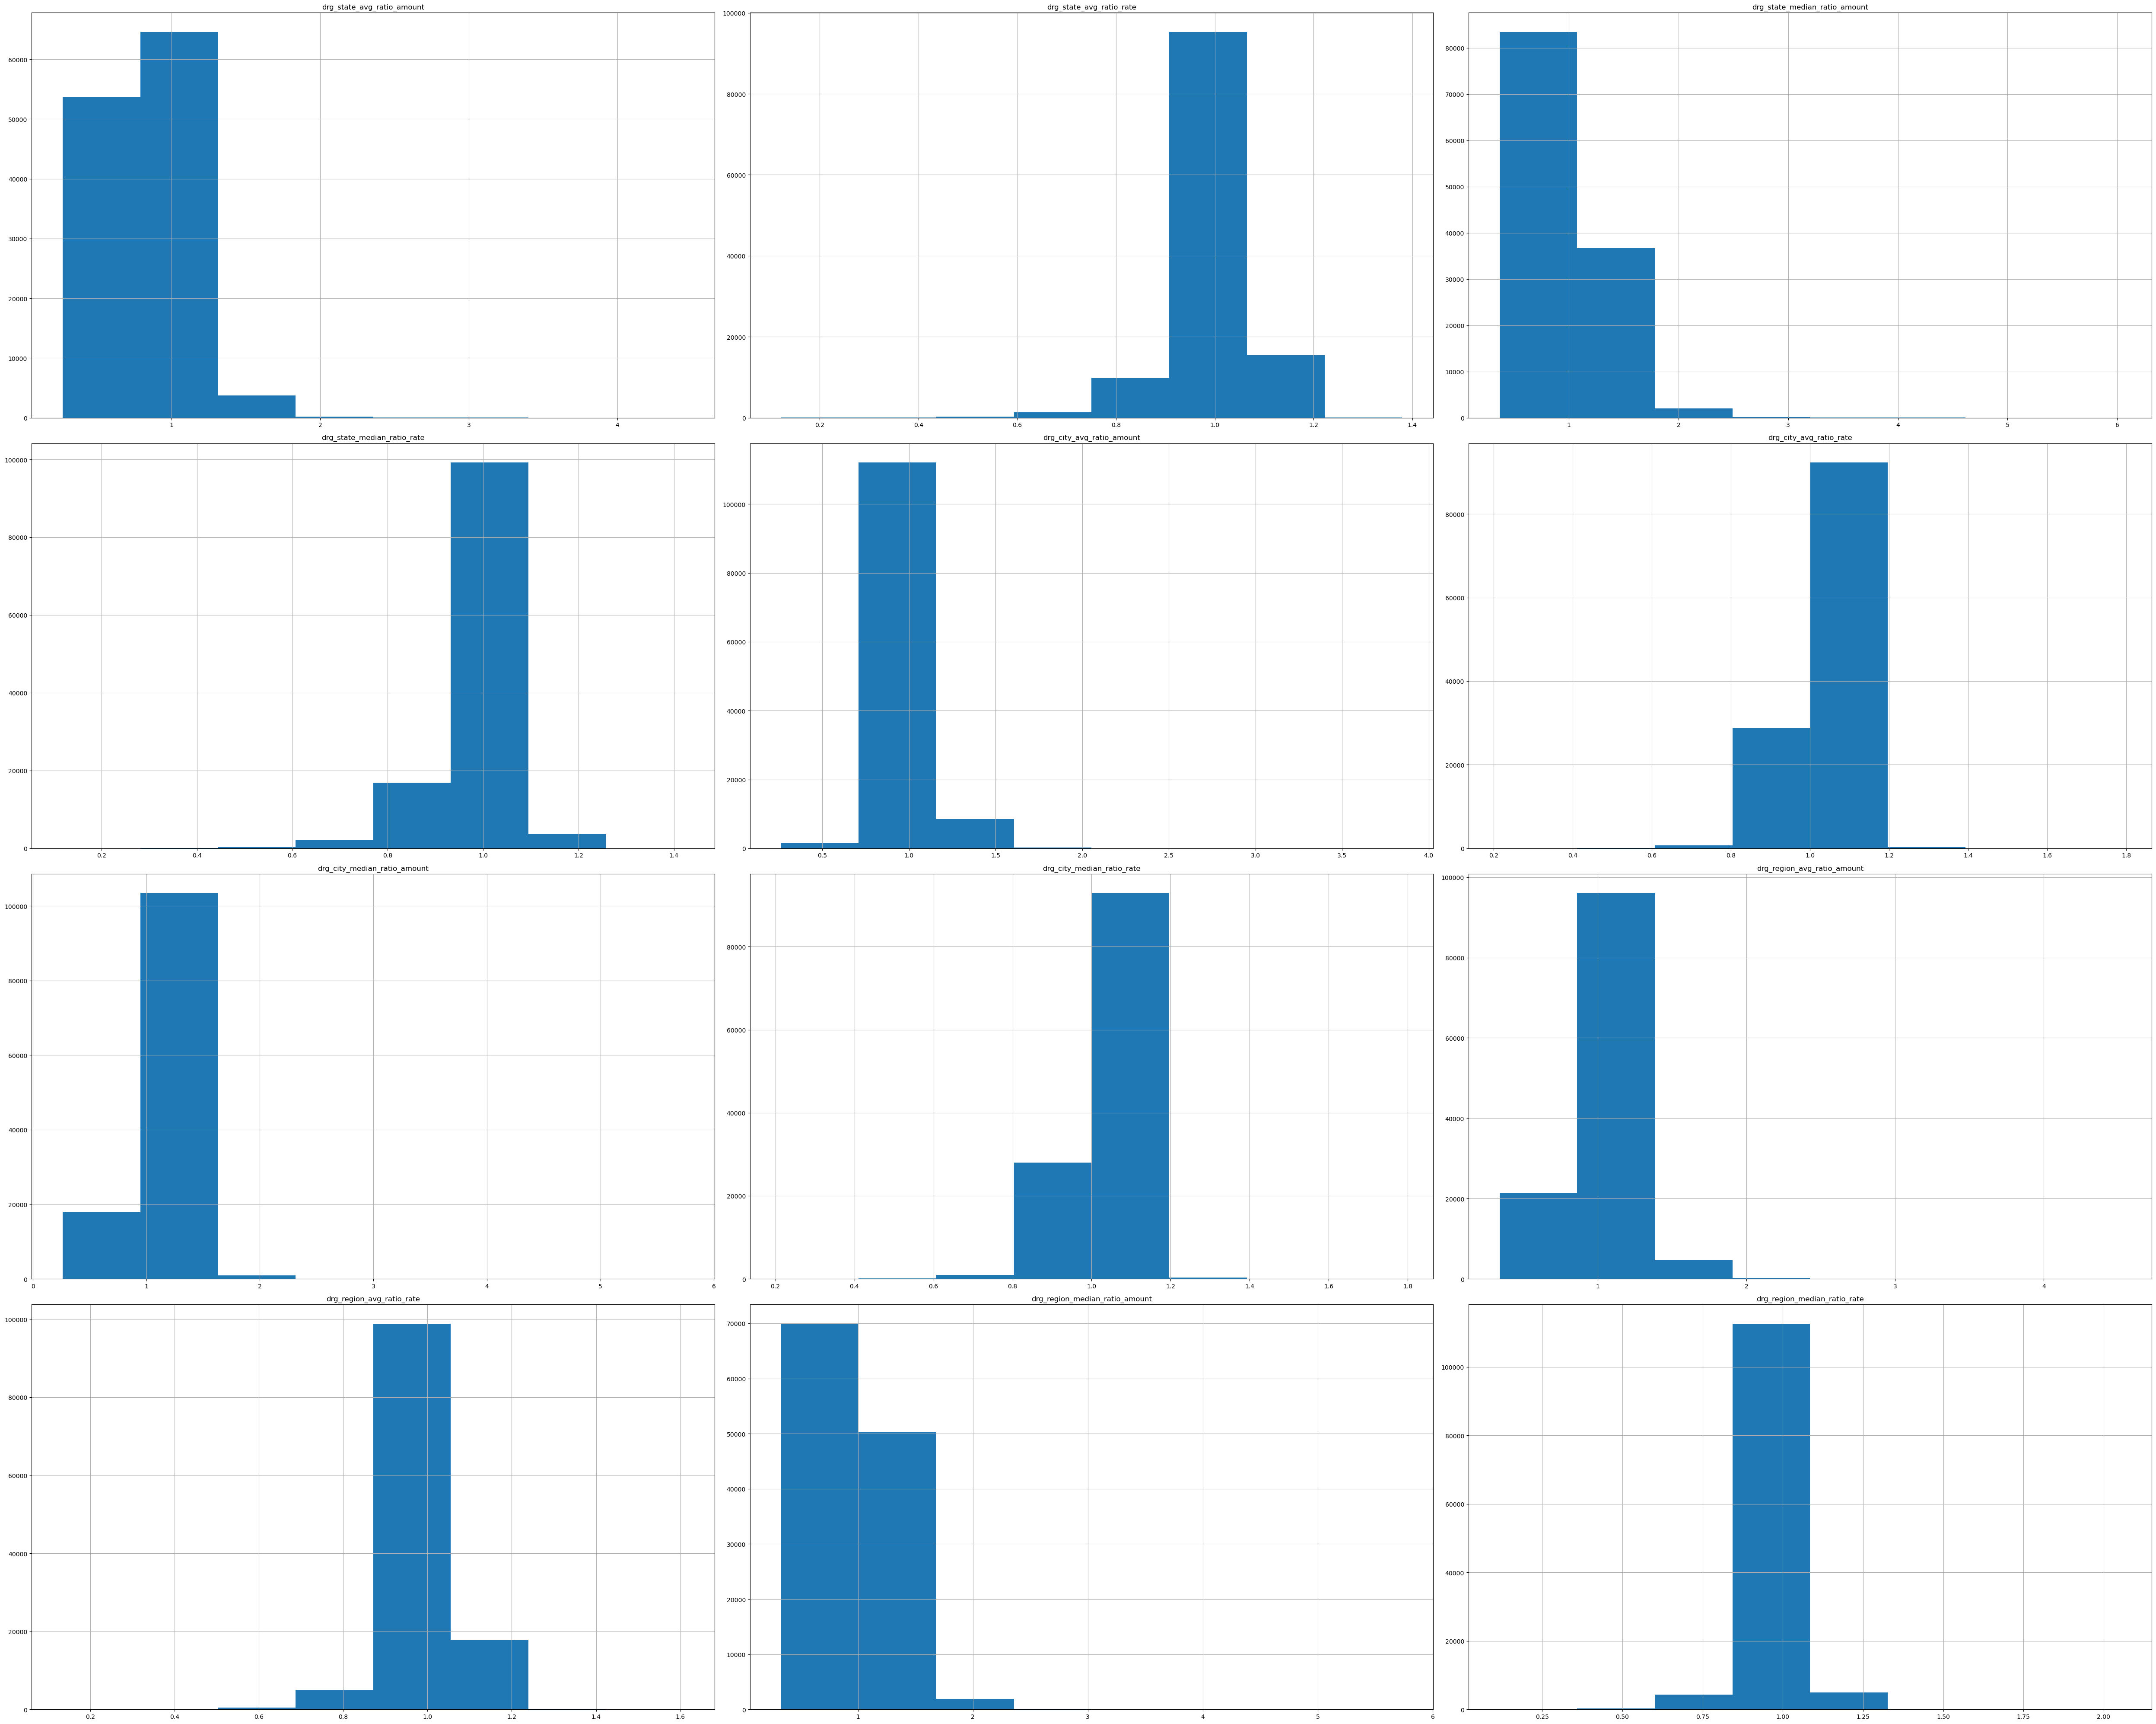

In [7]:
# Plot the distribution of all variables, setting number of bins as 8
X_train.hist(bins=8, figsize=(50, 40))
plt.tight_layout()
plt.show()

The distribution histograms show that all the variables are dispersed within a reasonable range. However, to identify specifically where most common and outlier drop in the distribution, I will use specific percentile to bin these variables and show the dispersed values more clearly. 

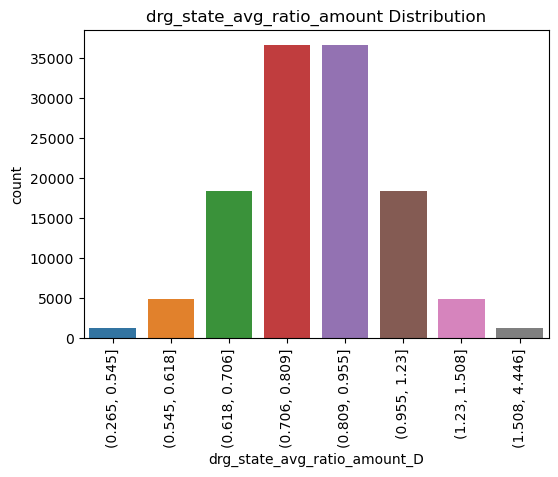

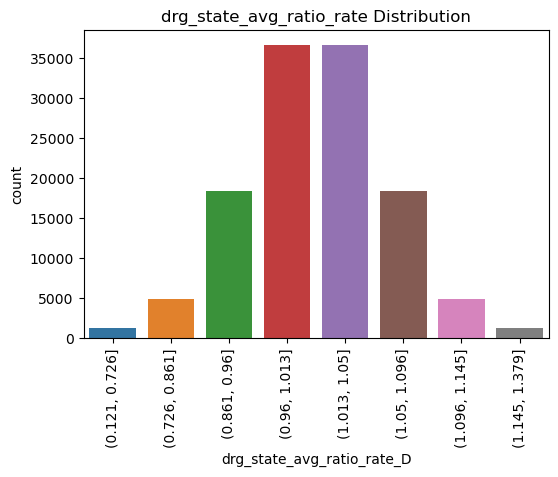

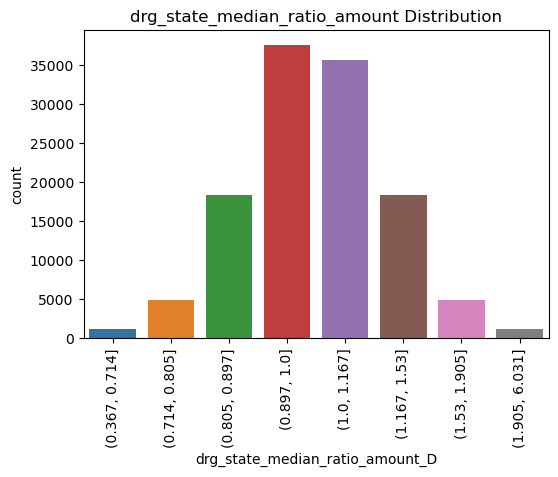

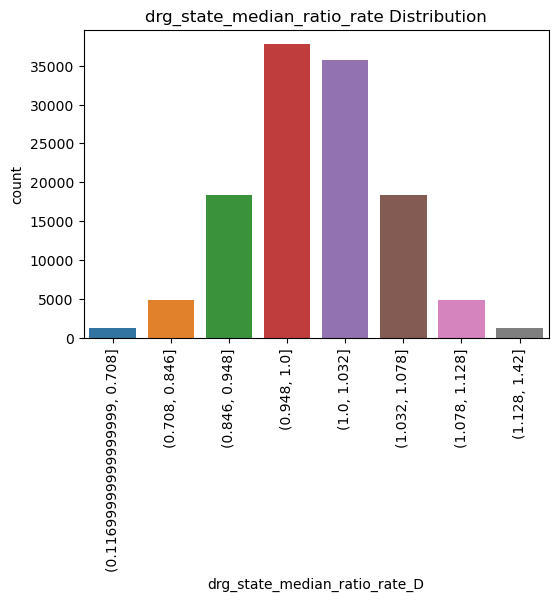

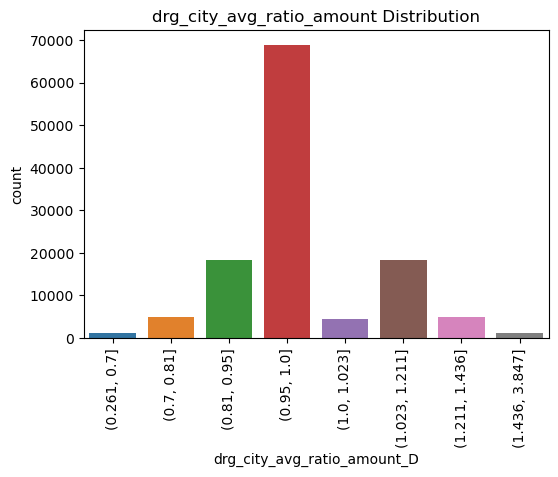

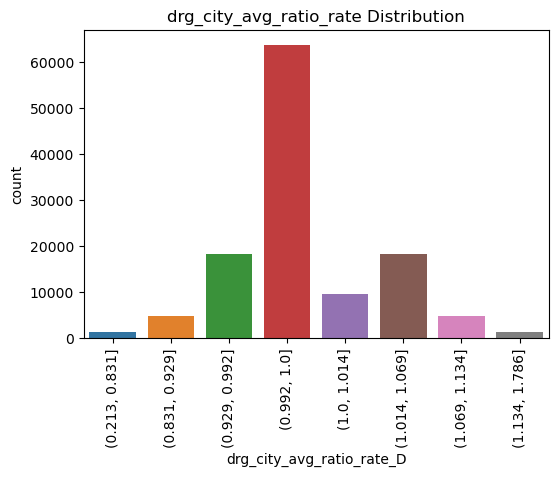

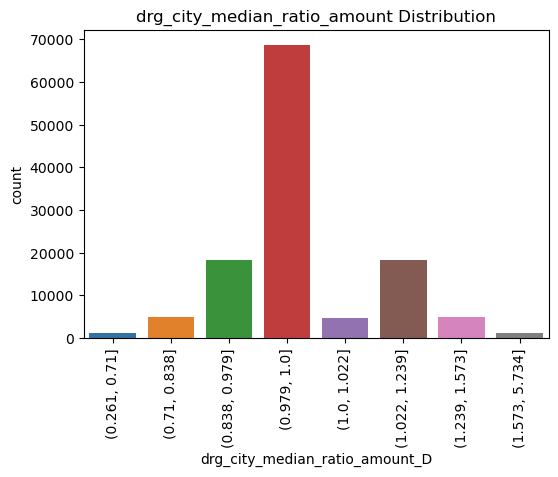

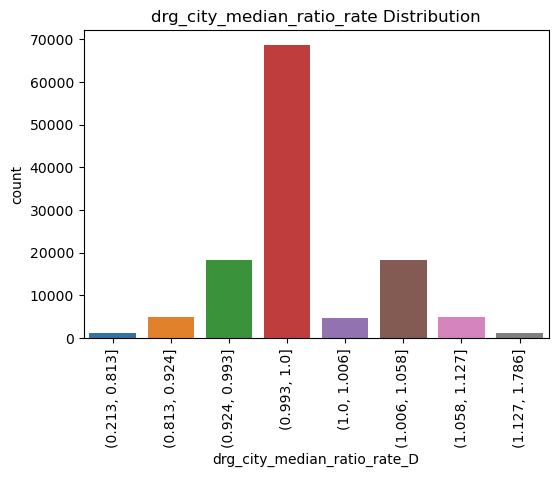

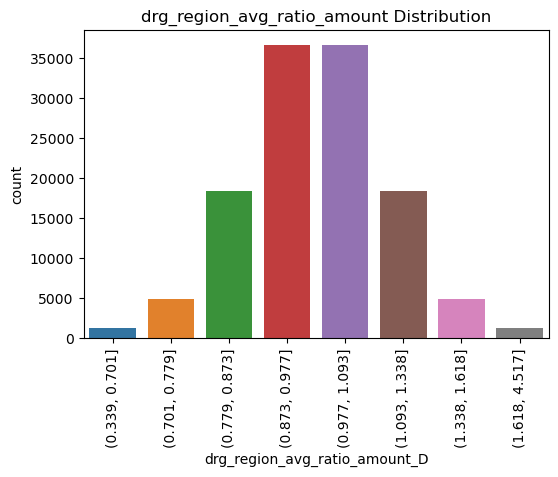

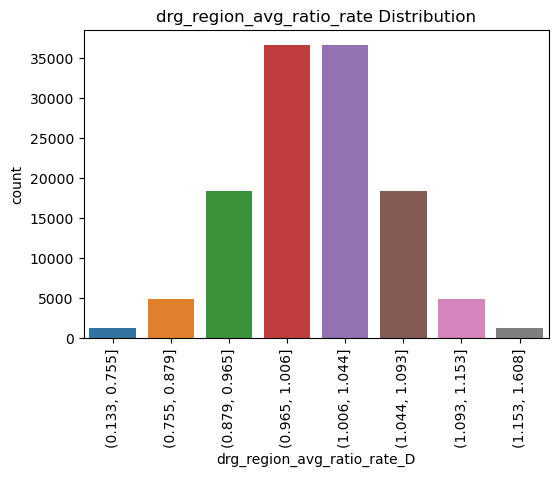

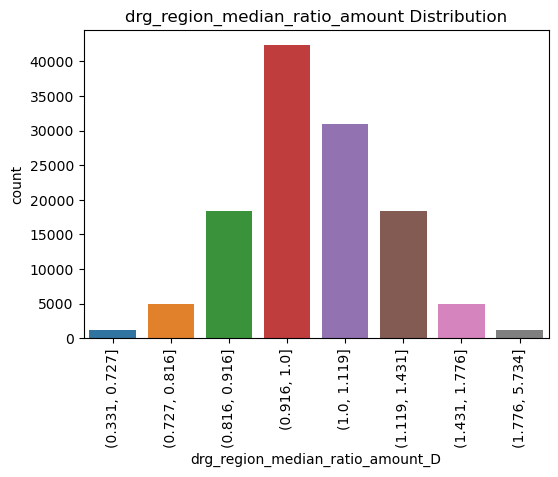

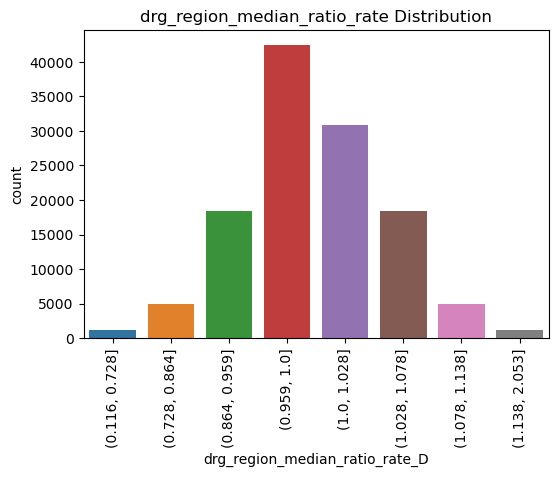

In [8]:
# Plot the distribution of all variables, binning with specific percentile 
X_train_D=X_train.copy()
for col in X_train_D.select_dtypes(include='number').columns:
    binned_var = col + '_D'

    # Sepefic percentiles: 
    ## 0 and 1 represent the minimum and maximum values
    ## 0.01, 0.05, 0.95, and 0.99 identify nearly extreme values (outliers)
    ## 0.2, 0.5, and 0.8 represent near quartiles values 
    percentile = [0, 0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99, 1]
    
    X_train_D[binned_var] = pd.qcut(X_train_D[col], percentile)
    plt.figure(figsize=(6, 4))
    g = sns.countplot(x=binned_var, data=X_train_D)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.title(col + ' Distribution')
    plt.show()

With the specific percentiles as bins, we can clearly see that the features grouping by City and DRG have extremely large amount of records dropping in the interval that covers 1.0, where all the other intervals have extremely small amount of records. It is very like caused by high level of data granuality. To better explain it, I will investigate the count of each category within the groups. If the count is mostly 1.0, that means the benchmarks are created out of a data point and are not credible.

In [9]:
# Benchmark Investigation
# Revert to the dataset with only raw data fields 
df = df_copy.iloc[:,:-12] 
# 1 Grouping by DRG & State
group1 = pd.DataFrame(df.groupby(['Provider_State', 'DRG']).size())
group1.columns = ['Count']
print(group1.describe())
# 2 Grouping by DRG & City
group2 = pd.DataFrame(df.groupby(['Provider_City', 'DRG']).size())
group2.columns = ['Count']
print(group2.describe())
# 3 Grouping by DRG & Hospital Referral Region
group3 = pd.DataFrame(df.groupby(['Hospital_referral_region_desp', 'DRG']).size())
group3.columns = ['Count']
print(group3.describe())

             Count
count  5025.000000
mean     32.450746
std      36.164995
min       1.000000
25%       7.000000
50%      21.000000
75%      44.000000
max     273.000000
               Count
count  105823.000000
mean        1.540922
std         1.371114
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        27.000000
              Count
count  28961.000000
mean       5.630503
std        6.350113
min        1.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       78.000000


The statistics show that the group of City and DRG indeed has the high data granuality issue. Counts of each category mostly are very low. The first 2 quartiles are equal to 1, and the 75th percentile is also very closed to 1. This group of features are too granular to reveal a pattern. It indicates that the benchmarks are created out of a data point and not credible. Therefore, I will drop this group of features and leave the other reasonable features to continue analysis and modelling. 

###  1.4 Feature Selection <a class="anchor" id="14"></a>

In [10]:
# Select the features that are more representative 
df = df_copy.copy().loc[:,['drg_state_avg_ratio_amount','drg_state_avg_ratio_rate','drg_state_median_ratio_amount','drg_state_median_ratio_rate','drg_region_avg_ratio_amount','drg_region_avg_ratio_rate','drg_region_median_ratio_amount','drg_region_median_ratio_rate']]

# Data split for train and test
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, random_state=0)

# Save a copy
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

## Section 2 Principal Component Analysis (PCA) <a class="anchor" id="2"></a>

Principal Component Analysis (PCA) performs a linear transformation to convert a set of data points of possibly correlated variables into a set of data points of linearly uncorrelated variables. In our healthcare fraud/abuse detection case, PCA is applicable because: 
1. Dimensionality Reduction: By transforming the data into a lower-dimensional space, PCA can simplify the analysis and visualization of the data while preserving the most important information. This reduction in dimensionality can be especially useful in detecting anomalies, as it focuses on the most significant components that contribute to the overall variation in the data.
2. Identifying Anomalous Patterns: PCA can reveal anomalous patterns in the data by identifying outliers in the transformed feature space. Anomalies are typically data points that deviate significantly from the normal patterns observed in the majority of the data. By projecting the data onto the principal components, PCA can highlight instances that are located far from the bulk of the data, indicating potential anomalies in Medicare hospital reimbursement records.

###  2.1 Build the model <a class="anchor" id="21"></a>

In [11]:
from pyod.models.pca import PCA
pca = PCA(contamination=0.05) 
pca.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = pca.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = pca.decision_scores_  # .decision_scores_ yields the raw outlier scores for the training data
y_train_scores = pca.decision_function(X_train) 
y_train_pred = pca.predict(X_train) 

y_test_scores = pca.decision_function(X_test) # You also can use .decision_function()
y_test_pred = pca.predict(X_test) 

Let’s see the default parameters of PCA. The default parameter for standardization is true, meaning it performs normalization before executing PCA. The contamination rate is set at 5%.

In [12]:
pca.get_params()

{'contamination': 0.05,
 'copy': True,
 'iterated_power': 'auto',
 'n_components': None,
 'n_selected_components': None,
 'random_state': None,
 'standardization': True,
 'svd_solver': 'auto',
 'tol': 0.0,
 'weighted': True,
 'whiten': False}

A very important metric in PCA is the explained variance ratio. It explains how much of the total variance is explained by each principal component. 

In [13]:
[pca.explained_variance_,
pca.explained_variance_ratio_]

[array([5.19207676, 2.11207034, 0.40904824, 0.14185842, 0.05936025,
        0.03856391, 0.03448546, 0.01260204]),
 array([0.64900429, 0.26400663, 0.05113061, 0.01773216, 0.00741997,
        0.00482045, 0.00431065, 0.00157524])]

The output below shows the first PC explains 64.9% variance, the second PC explains an additional 26.4%, the third 5.1%, and so on. The sum of the explained variance shall sum up to 100% for the eight principal components.

###  2.2 Determine the threshold <a class="anchor" id="22"></a>

PyOD has a built-in function that calculates the threshold value of the training data given the contamination rate. Because we have specified it as 5% in the model, the threshold is the value at 5%. The threshold to make 5% outliers is 7427.

In [14]:
print("The threshold for the defined comtanimation rate:" , pca.threshold_)

The threshold for the defined comtanimation rate: 7426.51160335812


In this project, we do not know the percentage of outliers. I will use the histogram of the outlier score to select a reasonable threshold.

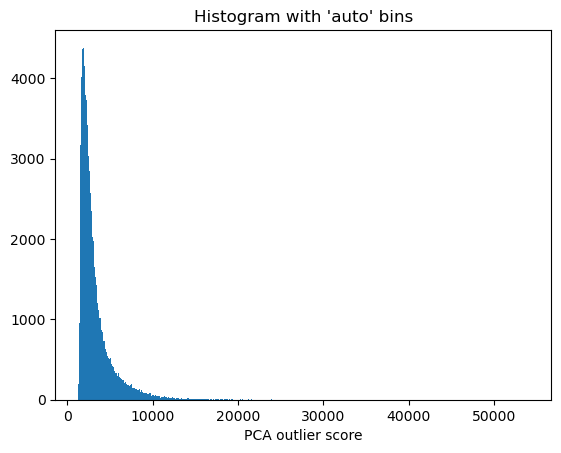

In [15]:
# get the prediction on the test data
y_test_pred = pca.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = pca.decision_function(X_test)  # outlier scores

import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('PCA outlier score')
plt.show()

The histogram of the PCA outlier score does not show a natural cut, but the amount of records become significantly small when the PCA outlier score is larger than 9,000. Therefore, I will set 9,000 as the threshold. 

###  2.3 Descriptive statistics of the normal and outlier groups <a class="anchor" id="23"></a>

Profiling the normal and outlier groups is a critical step to demonstrate the soundness of a model. The feature statistics of the normal and the abnormal groups should be consistent with our business understanding about healthcare industry and Medicare program.

In [16]:
threshold = 9000

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,drg_state_avg_ratio_amount,drg_state_avg_ratio_rate,drg_state_median_ratio_amount,drg_state_median_ratio_rate,drg_region_avg_ratio_amount,drg_region_avg_ratio_rate,drg_region_median_ratio_amount,drg_region_median_ratio_rate,Anomaly_Score
0,Normal,119095,97.380987,0.84,1.00,1.05,0.99,0.99,1.0,1.03,0.99,2998.96
1,Outlier,3203,2.619013,1.13,0.88,1.46,0.87,1.29,0.9,1.40,0.88,11872.54


In [17]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,drg_state_avg_ratio_amount,drg_state_avg_ratio_rate,drg_state_median_ratio_amount,drg_state_median_ratio_rate,drg_region_avg_ratio_amount,drg_region_avg_ratio_rate,drg_region_median_ratio_amount,drg_region_median_ratio_rate,Anomaly_Score
0,Normal,39765,97.54213,0.84,1.00,1.04,0.99,0.99,1.0,1.03,0.99,3000.54
1,Outlier,1002,2.45787,1.11,0.88,1.43,0.87,1.27,0.9,1.37,0.88,11727.50


The above tables present the characteristics of the normal and abnormal groups. It shows the count and count percentage of the normal and outlier groups. Both training and testing datasets generate similar performance. The tables tell us several important results (using training data as example):
- The size of the outlier group: Once a threshold is determined, the size is determined. With 9,000 PCA outlier score as the threshold, we've identified around 2.6% of outliers, and the remaining 97.4% of records drop into normal group. 
- The average anomaly score: The average score of the outlier group is much higher than that of the normal group (11,872.54 > 2,998.96). This evidence just verifies the data in the outlier group are outliers.
- The feature statistics in each group: 
    - Features using Average Medicare Payment Amount as benchmark: All of them have higher average values of the outlier group than the normal group.
        - drg_state_avg_ratio_amount: For the 'Normal' group, the average ratio of reimbursement amount for a specific Diagnosis-Related Group (DRG) in a state is approximately 0.84. In the outlier group, the average ratio is higher at around 1.13, suggesting a larger deviation from the expected or reference amount of Medicare program. It also indicates that the outlier group might claim larger amount for the same diagnosis compared to the their peers in the same state. 
        - drg_state_median_ratio_amount: The median ratio of reimbursement amount for a specific DRG in a state is 1.05 for the 'Normal' group and 1.46 for the 'Outlier' group. This suggests a higher deviation from the expected or reference amount in the 'Outlier' group. It also indicates that the outlier group might claim larger amount for the same diagnosis compared to the their peers in the same state. 
        - drg_region_avg_ratio_amount: The average ratio of reimbursement amount for a specific DRG in a region is 0.99 for the 'Normal' group and 1.29 for the 'Outlier' group. The higher ratio in the 'Outlier' group implies a larger deviation from the expected or reference amount. It also indicates that the outlier group might claim larger amount for the same diagnosis compared to the their peers in the same region. 
        - drg_region_median_ratio_amount: The median ratio of reimbursement amount for a specific DRG in a region is 1.03 for the 'Normal' group and 1.40 for the 'Outlier' group. This suggests a higher deviation from the expected or reference amount in the 'Outlier' group. It also indicates that the outlier group might claim larger amount for the same diagnosis compared to the their peers in the same region. 
    - Features using Average Medicare Reimburse Rate as benchmark: All of them have lower average values of the outier group than the normal group.
        - drg_state_avg_ratio_rate: In the 'Normal' group, the average ratio of reimbursement rate for a specific DRG in a state is 1.00. In the 'Outlier' group, the average ratio is slightly lower at approximately 0.88, indicating a lower reimbursement rate compared to the expected or reference rate. The reason can be the reinbursement request amount was so high that hit the regulated limit. It's also possible that the outlier group might have suspicious track record that made failed reinbursement. 
        - drg_state_median_ratio_rate: The median ratio of reimbursement rate for a specific DRG in a state is 0.99 for the 'Normal' group and 0.87 for the 'Outlier' group. This indicates a lower reimbursement rate relative to the expected or reference rate in the 'Outlier' group. The reason can be the reinbursement request amount was so high that hit the regulated limit. It's also possible that the outlier group might have suspicious track record that made failed reinbursement. 
        - drg_region_avg_ratio_rate: In the 'Normal' group, the average ratio of reimbursement rate for a specific DRG in a region is 1.00. In the 'Outlier' group, the average ratio is 0.90, indicating a lower reimbursement rate compared to the expected or reference rate. The reason can be the reinbursement request amount was so high that hit the regulated limit. It's also possible that the outlier group might have suspicious track record that made failed reinbursement. 
        - drg_region_median_ratio_rate: The median ratio of reimbursement rate for a specific DRG in a region is 0.99 for the 'Normal' group and 0.88 for the 'Outlier' group. This indicates a lower reimbursement rate relative to the expected or reference rate in the 'Outlier' group. The reason can be the reinbursement request amount was so high that hit the regulated limit. It's also possible that the outlier group might have suspicious track record that made failed reinbursement. 
- Business insights: 
The feature statistics can offer insights that helps to identify potential anomalies or irregularities in the Medicare hospital reimbursement records. Here are some potential business insights that can be derived from the given information:
    - Deviations from Expected Reimbursement Amounts: The higher average and median ratios of reimbursement amounts in the outlier group compared to the normal group may suggest instances where the actual reimbursement amounts significantly differ from the expected or reference amounts. This could warrant further investigation into potential reasons for these deviations.
    - Lower Reimbursement Rates: The lower average and median ratios of reimbursement rates in the outlier group indicate instances with lower reimbursement rates relative to the expected or reference rates. This might indicate situations where healthcare providers are reimbursed at a lower rate than usual, potentially requiring examination to understand the reasons behind these discrepancies.
    - Geographic Disparities: The variations in reimbursement ratios between states and regions can highlight potential geographic disparities in reimbursement practices. Anomalies in specific states or regions could be indicative of regional differences in billing, coding, or reimbursement practices, requiring further scrutiny.
    - Anomaly Scores: The significantly higher average anomaly score in the outlier group compared to the 'Normal' group suggests that instances classified as outlier exhibit more pronounced deviations from the normal behavior observed in the majority of the data. These higher anomaly scores can help prioritize and flag potentially suspicious or irregular cases for closer investigation.

## Section 3 K-nearest neighbor algorithm (KNNs) <a class="anchor" id="3"></a>

The K-nearest neighbor algorithm (KNNs) can be used for the computation of the distance to the k neighbors. Because it does not use a target variable, some on-line sources such as the scikit-learn KNN calls it unsupervised learning. The KNN in PyOD computes the distance to the k neighbors and uses the distance to define the outlier scores. It can be used for anomaly detection in the healthcare industry. Here are some reasons why KNNs is applicable in this healthcare fraud/abuse detection case:
1. Distance-based Anomaly Detection: KNN is a distance-based algorithm that measures the similarity or distance between data points. In the context of Medicare hospital reimbursement records, KNN can identify instances that deviate significantly from their nearest neighbors. This makes it effective in detecting anomalies that may indicate potential fraud or healthcare resource abuse. Unusual reimbursement patterns or outliers that differ significantly from normal cases can be identified by considering their distance from neighboring instances.
2. Non-parametric Approach: KNN is a non-parametric algorithm, meaning it does not assume a specific data distribution. This flexibility is crucial in the healthcare industry, where reimbursement records can exhibit complex and diverse patterns. KNN adapts to different data distributions and can capture anomalies across various reimbursement scenarios without making strong assumptions. This adaptability is valuable when detecting potential fraud or healthcare resource abuse, which can manifest in different forms and patterns.
3. Local Outlier Detection: KNN focuses on the local neighborhood of each data point by considering the k nearest neighbors. This is especially relevant in healthcare anomaly detection as anomalies may occur in localized regions or subgroups of the data. KNN can effectively capture local abnormalities or clusters of anomalous instances within Medicare hospital reimbursement records. By analyzing local patterns and detecting outliers in the vicinity of each instance, KNN can highlight potential cases of fraud or healthcare resource abuse that may exhibit distinct local behaviors.

###  3.1 Build the model <a class="anchor" id="31"></a>

In [18]:
X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

from pyod.utils.utility import standardizer
# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

from pyod.models.knn import KNN
knn = KNN(contamination=0.05) 
knn.fit(X_train_norm)

# Training data
y_train_scores = knn.decision_function(X_train_norm)
y_train_pred = knn.predict(X_train_norm)

# Test data
y_test_scores = knn.decision_function(X_test_norm)
y_test_pred = knn.predict(X_test_norm) # outlier labels (0 or 1)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , knn.threshold_)

The training data: {0: 116921, 1: 5377}
The training data: {0: 38831, 1: 1936}
The threshold for the defined comtanimation rate: 0.6406322033417481


Let’s see the default parameters of KNN. The number of neighbors is 5.0. The contamination rate is set at 5%.

In [19]:
knn.get_params()

{'algorithm': 'auto',
 'contamination': 0.05,
 'leaf_size': 30,
 'method': 'largest',
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 5,
 'p': 2,
 'radius': 1.0}

###  3.2 Determine the threshold<a class="anchor" id="32"></a>

In this project, we do not know the percentage of outliers. I will use the histogram of the outlier score to select a reasonable threshold.

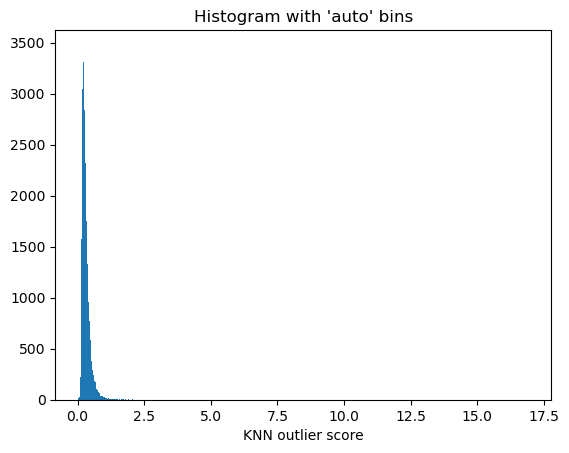

In [20]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('KNN outlier score')
plt.show()

The histogram of the KNN outlier score does not show a natural cut, but the amount of records become significantly small when the KNN outlier score is larger than 0.7. Therefore, I will set 0.7 as the threshold.

###  3.3 Descriptive statistics of the normal and outlier groups <a class="anchor" id="33"></a>

In [21]:
threshold = 0.7

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,drg_state_avg_ratio_amount,drg_state_avg_ratio_rate,drg_state_median_ratio_amount,drg_state_median_ratio_rate,drg_region_avg_ratio_amount,drg_region_avg_ratio_rate,drg_region_median_ratio_amount,drg_region_median_ratio_rate,Anomaly_Score
0,Normal,118365,96.784085,0.84,1.00,1.04,0.99,0.99,1.00,1.03,0.99,0.29
1,Outlier,3933,3.215915,1.06,0.97,1.39,0.95,1.23,1.01,1.31,0.99,0.99


In [22]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,drg_state_avg_ratio_amount,drg_state_avg_ratio_rate,drg_state_median_ratio_amount,drg_state_median_ratio_rate,drg_region_avg_ratio_amount,drg_region_avg_ratio_rate,drg_region_median_ratio_amount,drg_region_median_ratio_rate,Anomaly_Score
0,Normal,39350,96.524149,0.84,1.00,1.04,0.99,0.99,1.0,1.03,0.99,0.30
1,Outlier,1417,3.475851,1.04,0.97,1.35,0.95,1.20,1.0,1.28,0.98,1.01


The above tables present the characteristics of the normal and abnormal groups. It shows the count and count percentage of the normal and outlier groups. Both training and testing datasets generate similar performance. The tables tell us several important results (using training data as example):
- The size of the outlier group: Once a threshold is determined, the size is determined. With 0.7 KNN outlier score as the threshold, we've identified around 3.2% of outliers, and the remaining 96.8% of records drop into normal group. 
- The average anomaly score: The average score of the outlier group is much higher than that of the normal group (0.99 > 0.29). 
- The feature statistics in each group: 
    - Features using Average Medicare Payment Amount as benchmark: All of them have higher average values of the outlier group than the normal group.
        - drg_state_avg_ratio_amount: For the 'Normal' group, the average ratio of reimbursement amount for a specific Diagnosis-Related Group (DRG) in a state is approximately 0.84. In the outlier group, the average ratio is higher at around 1.04, suggesting a larger deviation from the expected or reference amount of Medicare program. It also indicates that the outlier group might claim larger amount for the same diagnosis compared to the their peers in the same state. 
        - drg_state_median_ratio_amount: The median ratio of reimbursement amount for a specific DRG in a state is 1.04 for the 'Normal' group and 1.35 for the 'Outlier' group. This suggests a higher deviation from the expected or reference amount in the 'Outlier' group. It also indicates that the outlier group might claim larger amount for the same diagnosis compared to the their peers in the same state. 
        - drg_region_avg_ratio_amount: The average ratio of reimbursement amount for a specific DRG in a region is 0.99 for the 'Normal' group and 1.20 for the 'Outlier' group. The higher ratio in the 'Outlier' group implies a larger deviation from the expected or reference amount. It also indicates that the outlier group might claim larger amount for the same diagnosis compared to the their peers in the same region. 
        - drg_region_median_ratio_amount: The median ratio of reimbursement amount for a specific DRG in a region is 1.03 for the 'Normal' group and 1.28 for the 'Outlier' group. This suggests a higher deviation from the expected or reference amount in the 'Outlier' group. It also indicates that the outlier group might claim larger amount for the same diagnosis compared to the their peers in the same region. 
    - Features using Average Medicare Reimburse Rate as benchmark: All of them have lower average values of the outier group than the normal group.
        - drg_state_avg_ratio_rate: In the 'Normal' group, the average ratio of reimbursement rate for a specific DRG in a state is 1.00. In the 'Outlier' group, the average ratio is slightly lower at approximately 0.97, indicating a lower reimbursement rate compared to the expected or reference rate. The reason can be the reinbursement request amount was so high that hit the regulated limit. It's also possible that the outlier group might have suspicious track record that made failed reinbursement. 
        - drg_state_median_ratio_rate: The median ratio of reimbursement rate for a specific DRG in a state is 0.99 for the 'Normal' group and 0.95 for the 'Outlier' group. This indicates a lower reimbursement rate relative to the expected or reference rate in the 'Outlier' group. The reason can be the reinbursement request amount was so high that hit the regulated limit. It's also possible that the outlier group might have suspicious track record that made failed reinbursement. 
        - drg_region_avg_ratio_rate: In the 'Normal' group, the average ratio of reimbursement rate for a specific DRG in a region is 1.00. In the 'Outlier' group, the average ratio is 1.01. The difference is too small to justify further business insights. Therefore, I will drop it and iterate the model.
        - drg_region_median_ratio_rate: The median ratio of reimbursement rate for a specific DRG in a region is 0.99 for the 'Normal' group and 0.99 for the 'Outlier' group. There's no difference to justify further business insights. Therefore, I will drop it and iterate the model.
- Business insights: 
The feature statistics can offer insights that helps to identify potential anomalies or irregularities in the Medicare hospital reimbursement records. Here are some potential business insights that can be derived from the given information:
    - Deviations from Expected Reimbursement Amounts: The higher average and median ratios of reimbursement amounts in the outlier group compared to the normal group may suggest instances where the actual reimbursement amounts significantly differ from the expected or reference amounts. This could warrant further investigation into potential reasons for these deviations.
    - Lower Reimbursement Rates: The lower average and median ratios of reimbursement rates in the outlier group indicate instances with lower reimbursement rates relative to the expected or reference rates. This might indicate situations where healthcare providers are reimbursed at a lower rate than usual, potentially requiring examination to understand the reasons behind these discrepancies.
    - Geographic Disparities: The variations in reimbursement ratios between states and regions can highlight potential geographic disparities in reimbursement practices. Anomalies in specific states or regions could be indicative of regional differences in billing, coding, or reimbursement practices, requiring further scrutiny.
    - Anomaly Scores: The significantly higher average anomaly score in the outlier group compared to the 'Normal' group suggests that instances classified as outlier exhibit more pronounced deviations from the normal behavior observed in the majority of the data. These higher anomaly scores can help prioritize and flag potentially suspicious or irregular cases for closer investigation.

###  3.4 Model Iteration <a class="anchor" id="34"></a>

In [23]:
# Drop the features that cannot be properly explained 
X_train = X_train_copy.copy().drop(['drg_region_avg_ratio_rate','drg_region_median_ratio_rate'],axis=1)
X_test = X_test_copy.copy().drop(['drg_region_avg_ratio_rate','drg_region_median_ratio_rate'],axis=1)

# Save a copy 
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [24]:
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Build model
knn = KNN(contamination=0.05) 
knn.fit(X_train_norm)

# Training data
y_train_scores = knn.decision_function(X_train_norm)
y_train_pred = knn.predict(X_train_norm)

# Test data
y_test_scores = knn.decision_function(X_test_norm)
y_test_pred = knn.predict(X_test_norm) # outlier labels (0 or 1)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , knn.threshold_)

The training data: {0: 116992, 1: 5306}
The training data: {0: 38811, 1: 1956}
The threshold for the defined comtanimation rate: 0.4397873338597961


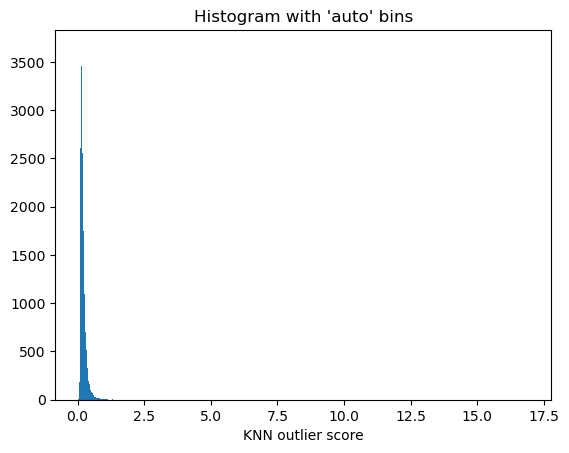

In [25]:
# Plot the outlier score to decide threshold
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('KNN outlier score')
plt.show()

In [26]:
# Descriptive statistics for normal and outlier 
threshold = 0.5

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,drg_state_avg_ratio_amount,drg_state_avg_ratio_rate,drg_state_median_ratio_amount,drg_state_median_ratio_rate,drg_region_avg_ratio_amount,drg_region_median_ratio_amount,Anomaly_Score
0,Normal,118920,97.237894,0.84,1.00,1.04,0.99,0.99,1.03,0.20
1,Outlier,3378,2.762106,1.18,0.98,1.54,0.96,1.30,1.41,0.73


In [27]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,drg_state_avg_ratio_amount,drg_state_avg_ratio_rate,drg_state_median_ratio_amount,drg_state_median_ratio_rate,drg_region_avg_ratio_amount,drg_region_median_ratio_amount,Anomaly_Score
0,Normal,39496,96.882282,0.84,1.00,1.04,0.99,0.99,1.03,0.20
1,Outlier,1271,3.117718,1.15,0.98,1.50,0.96,1.27,1.37,0.75


The above tables present the characteristics of the normal and abnormal groups. It shows the count and count percentage of the normal and outlier groups. Both training and testing datasets generate similar performance. The tables tell us several important results (using training data as example):
- The size of the outlier group: Once a threshold is determined, the size is determined. With 0.5 KNN outlier score as the threshold, we've identified around 2.7% of outliers, and the remaining 97.2% of records drop into normal group. 
- The average anomaly score: The average score of the outlier group is much higher than that of the normal group (0.73 > 0.20). 
- The feature statistics in each group: 
    - Features using Average Medicare Payment Amount as benchmark: All of them have higher average values of the outlier group than the normal group.
        - drg_state_avg_ratio_amount: For the 'Normal' group, the average ratio of reimbursement amount for a specific Diagnosis-Related Group (DRG) in a state is approximately 0.84. In the outlier group, the average ratio is higher at around 1.18, suggesting a larger deviation from the expected or reference amount of Medicare program. It also indicates that the outlier group might claim larger amount for the same diagnosis compared to the their peers in the same state. 
        - drg_state_median_ratio_amount: The median ratio of reimbursement amount for a specific DRG in a state is 1.04 for the 'Normal' group and 1.50 for the 'Outlier' group. This suggests a higher deviation from the expected or reference amount in the 'Outlier' group. It also indicates that the outlier group might claim larger amount for the same diagnosis compared to the their peers in the same state. 
        - drg_region_avg_ratio_amount: The average ratio of reimbursement amount for a specific DRG in a region is 0.99 for the 'Normal' group and 1.27 for the 'Outlier' group. The higher ratio in the 'Outlier' group implies a larger deviation from the expected or reference amount. It also indicates that the outlier group might claim larger amount for the same diagnosis compared to the their peers in the same region. 
        - drg_region_median_ratio_amount: The median ratio of reimbursement amount for a specific DRG in a region is 1.03 for the 'Normal' group and 1.37 for the 'Outlier' group. This suggests a higher deviation from the expected or reference amount in the 'Outlier' group. It also indicates that the outlier group might claim larger amount for the same diagnosis compared to the their peers in the same region. 
    - Features using Average Medicare Reimburse Rate as benchmark: All of them have lower average values of the outier group than the normal group.
        - drg_state_avg_ratio_rate: In the 'Normal' group, the average ratio of reimbursement rate for a specific DRG in a state is 1.00. In the 'Outlier' group, the average ratio is slightly lower at approximately 0.98, indicating a lower reimbursement rate compared to the expected or reference rate. The reason can be the reinbursement request amount was so high that hit the regulated limit. It's also possible that the outlier group might have suspicious track record that made failed reinbursement. 
        - drg_state_median_ratio_rate: The median ratio of reimbursement rate for a specific DRG in a state is 0.99 for the 'Normal' group and 0.96 for the 'Outlier' group. This indicates a lower reimbursement rate relative to the expected or reference rate in the 'Outlier' group. The reason can be the reinbursement request amount was so high that hit the regulated limit. It's also possible that the outlier group might have suspicious track record that made failed reinbursement. 
- Business insights: 
The feature statistics can offer insights that helps to identify potential anomalies or irregularities in the Medicare hospital reimbursement records. Here are some potential business insights that can be derived from the given information:
    - Deviations from Expected Reimbursement Amounts: The higher average and median ratios of reimbursement amounts in the outlier group compared to the normal group may suggest instances where the actual reimbursement amounts significantly differ from the expected or reference amounts. This could warrant further investigation into potential reasons for these deviations.
    - Lower Reimbursement Rates: The lower average and median ratios of reimbursement rates in the outlier group indicate instances with lower reimbursement rates relative to the expected or reference rates. This might indicate situations where healthcare providers are reimbursed at a lower rate than usual, potentially requiring examination to understand the reasons behind these discrepancies.
    - Geographic Disparities: The variations in reimbursement ratios between states and regions can highlight potential geographic disparities in reimbursement practices. Anomalies in specific states or regions could be indicative of regional differences in billing, coding, or reimbursement practices, requiring further scrutiny.
    - Anomaly Scores: The significantly higher average anomaly score in the outlier group compared to the 'Normal' group suggests that instances classified as outlier exhibit more pronounced deviations from the normal behavior observed in the majority of the data. These higher anomaly scores can help prioritize and flag potentially suspicious or irregular cases for closer investigation.

###  3.5 Achieve model stability by aggregating multiple models <a class="anchor" id="35"></a>

KNNs can be sensitive to the choice of k. To produce a model with a stable outcome, the best practice is to build multiple KNN models and then aggregate the scores. This approach will reduce the chance of overfitting and increase prediction accuracy.

In [28]:
X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

from pyod.models.combination import aom, moa, average, maximization

# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)
# Test a range of k-neighbors from 10 to 200. There will be 10 k-NN models.
k_list = [10, 30, 50, 70, 90, 110, 130, 150, 170, 200]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape
# Modeling
for i in range(n_clf):
    k = k_list[i]
    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train_norm)

    # Store the results in each column:
    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test_norm) 
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

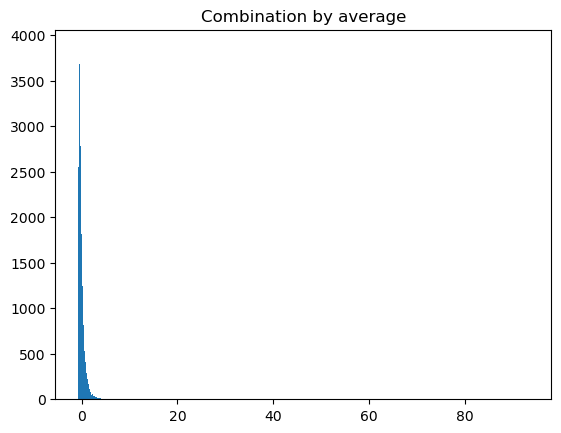

In [29]:
# Combination by average
# The test_scores_norm is 500 x 10. The "average" function will take the average of the 10 columns. 
# The result "y_by_average" is a single column: 
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [30]:
descriptive_stat_threshold(X_train,y_train_by_average, 2)

,Group,Count,Count %,drg_state_avg_ratio_amount,drg_state_avg_ratio_rate,drg_state_median_ratio_amount,drg_state_median_ratio_rate,drg_region_avg_ratio_amount,drg_region_median_ratio_amount,Anomaly_Score
0,Normal,119293,97.542887,0.84,1.00,1.04,0.99,0.99,1.03,-0.10
1,Outlier,3005,2.457113,1.22,0.95,1.59,0.94,1.31,1.41,3.88


In [31]:
descriptive_stat_threshold(X_test,y_test_by_average, 2)

,Group,Count,Count %,drg_state_avg_ratio_amount,drg_state_avg_ratio_rate,drg_state_median_ratio_amount,drg_state_median_ratio_rate,drg_region_avg_ratio_amount,drg_region_median_ratio_amount,Anomaly_Score
0,Normal,39810,97.652513,0.84,1.00,1.04,0.99,0.99,1.03,-0.10
1,Outlier,957,2.347487,1.21,0.96,1.57,0.94,1.29,1.39,3.82


The above tables present the characteristics of the normal and abnormal groups. It shows the count and count percentage of the normal and outlier groups. Both training and testing datasets generate similar performance. The tables tell us several important results (using training data as example):
- The size of the outlier group: Once a threshold is determined, the size is determined. With 2 KNN outlier score as the threshold, we've identified around 2.5% of outliers, and the remaining 97.5% of records drop into normal group. 
- The average anomaly score: The average score of the outlier group is much higher than that of the normal group (3.88 > -0.1). 
- The feature statistics in each group: 
    - Features using Average Medicare Payment Amount as benchmark: All of them have higher average values of the outlier group than the normal group.
        - drg_state_avg_ratio_amount: For the 'Normal' group, the average ratio of reimbursement amount for a specific Diagnosis-Related Group (DRG) in a state is approximately 0.84. In the outlier group, the average ratio is higher at around 1.22, suggesting a larger deviation from the expected or reference amount of Medicare program. It also indicates that the outlier group might claim larger amount for the same diagnosis compared to the their peers in the same state. 
        - drg_state_median_ratio_amount: The median ratio of reimbursement amount for a specific DRG in a state is 1.04 for the 'Normal' group and 1.59 for the 'Outlier' group. This suggests a higher deviation from the expected or reference amount in the 'Outlier' group. It also indicates that the outlier group might claim larger amount for the same diagnosis compared to the their peers in the same state. 
        - drg_region_avg_ratio_amount: The average ratio of reimbursement amount for a specific DRG in a region is 0.99 for the 'Normal' group and 1.29 for the 'Outlier' group. The higher ratio in the 'Outlier' group implies a larger deviation from the expected or reference amount. It also indicates that the outlier group might claim larger amount for the same diagnosis compared to the their peers in the same region. 
        - drg_region_median_ratio_amount: The median ratio of reimbursement amount for a specific DRG in a region is 1.03 for the 'Normal' group and 1.39 for the 'Outlier' group. This suggests a higher deviation from the expected or reference amount in the 'Outlier' group. It also indicates that the outlier group might claim larger amount for the same diagnosis compared to the their peers in the same region. 
    - Features using Average Medicare Reimburse Rate as benchmark: All of them have lower average values of the outier group than the normal group.
        - drg_state_avg_ratio_rate: In the 'Normal' group, the average ratio of reimbursement rate for a specific DRG in a state is 1.00. In the 'Outlier' group, the average ratio is slightly lower at approximately 0.95, indicating a lower reimbursement rate compared to the expected or reference rate. The reason can be the reinbursement request amount was so high that hit the regulated limit. It's also possible that the outlier group might have suspicious track record that made failed reinbursement. 
        - drg_state_median_ratio_rate: The median ratio of reimbursement rate for a specific DRG in a state is 0.99 for the 'Normal' group and 0.94 for the 'Outlier' group. This indicates a lower reimbursement rate relative to the expected or reference rate in the 'Outlier' group. The reason can be the reinbursement request amount was so high that hit the regulated limit. It's also possible that the outlier group might have suspicious track record that made failed reinbursement. 
- Business insights: 
The feature statistics can offer insights that helps to identify potential anomalies or irregularities in the Medicare hospital reimbursement records. Here are some potential business insights that can be derived from the given information:
    - Deviations from Expected Reimbursement Amounts: The higher average and median ratios of reimbursement amounts in the outlier group compared to the normal group may suggest instances where the actual reimbursement amounts significantly differ from the expected or reference amounts. This could warrant further investigation into potential reasons for these deviations.
    - Lower Reimbursement Rates: The lower average and median ratios of reimbursement rates in the outlier group indicate instances with lower reimbursement rates relative to the expected or reference rates. This might indicate situations where healthcare providers are reimbursed at a lower rate than usual, potentially requiring examination to understand the reasons behind these discrepancies.
    - Geographic Disparities: The variations in reimbursement ratios between states and regions can highlight potential geographic disparities in reimbursement practices. Anomalies in specific states or regions could be indicative of regional differences in billing, coding, or reimbursement practices, requiring further scrutiny.
    - Anomaly Scores: The significantly higher average anomaly score in the outlier group compared to the 'Normal' group suggests that instances classified as outlier exhibit more pronounced deviations from the normal behavior observed in the majority of the data. These higher anomaly scores can help prioritize and flag potentially suspicious or irregular cases for closer investigation.

## Section 4 Conclusion <a class="anchor" id="4"></a>

###  4.1 Outliers Identified by Multiple Models <a class="anchor" id="41"></a>

If an outlier is identified by multiple models, the chance that it is an outlier is much higher. We have used PCA and KNNs in this project. We have also discussed about HBOS and ECOD for anolmaly detection in the previous credit card project. In this section, I am going to cross-tabulate the predictions of these four models to identify outliers.

In [32]:
X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

########
# HBOS #
########
from pyod.models.hbos import HBOS
n_bins = 50
hbos = HBOS(n_bins=n_bins,contamination=0.05) 
hbos.fit(X_train)
y_train_hbos_scores = hbos.decision_function(X_train)

########
# ECOD #
########
from pyod.models.ecod import ECOD
clf_name = 'ECOD'
ecod = ECOD(contamination=0.05) 
ecod.fit(X_train)
y_train_ecod_scores = ecod.decision_function(X_train)

########
# PCA  #
########
pca = PCA(contamination=0.05) 
pca.fit(X_train)
y_train_pca_scores = pca.decision_function(X_train) 

########
# KNN  #
########
X_train_norm = standardizer(X_train)
knn = KNN(contamination=0.05) 
knn.fit(X_train_norm)
y_train_knn_scores = knn.decision_function(X_train_norm)


# Thresholds
[ecod.threshold_, hbos.threshold_, pca.threshold_, knn.threshold_]

[19.15315568689639, 4.04695119536891, 3473.45748188306, 0.4397873338597961]

In [33]:
# Put the outlier scores of four models together
Actual_preds = pd.DataFrame({
                             'HBO_Score': y_train_hbos_scores, 
                             'ECOD_Score': y_train_ecod_scores, 
                             'PCA_Score': y_train_pca_scores, 
                             'KNN_Score': y_train_knn_scores})
Actual_preds['HBOS_pred'] = np.where(Actual_preds['HBO_Score']>hbos.threshold_,1,0)
Actual_preds['ECOD_pred'] = np.where(Actual_preds['ECOD_Score']>ecod.threshold_,1,0)
Actual_preds['PCA_pred'] = np.where(Actual_preds['PCA_Score']>pca.threshold_,1,0)
Actual_preds['KNN_pred'] = np.where(Actual_preds['KNN_Score']>knn.threshold_,1,0)
Actual_preds

,HBO_Score,ECOD_Score,PCA_Score,KNN_Score,HBOS_pred,ECOD_pred,PCA_pred,KNN_pred
0,-7.677914,10.280019,1376.784248,0.266443,0,0,0,0
1,-1.875488,12.462646,2147.201858,0.238377,0,0,0,0
2,-9.561356,8.345992,1173.245445,0.191618,0,0,0,0
3,-12.434814,6.252707,909.077868,0.163672,0,0,0,0
4,-10.211809,6.794850,897.473064,0.116839,0,0,0,0
...,...,...,...,...,...,...,...,...
122293,-3.629189,11.898882,2689.414801,0.253674,0,0,0,0
122294,4.990488,16.472535,2975.281273,0.696785,1,0,0,1
122295,-8.579039,7.117483,871.786172,0.138281,0,0,0,0
122296,-11.488908,7.317185,1053.767638,0.144342,0,0,0,0


When I cross-tabulate the PCA and the KNNs predictions, 2633 observations are identified by both models to be outliers.

In [34]:
pd.crosstab(Actual_preds['PCA_pred'],Actual_preds['KNN_pred'])

KNN_pred,0,1
PCA_pred,,
0,113510,2673
1,3482,2633


When I cross-check the predictions of all the four models, 1939 observations are identified by all the models to be outliers, which is around 1.6% of the total training dataset. This cross-examination is helpful especially if there is no ground truth. 

In [35]:
((Actual_preds['PCA_pred'] == 1) &
 (Actual_preds['KNN_pred'] == 1) &
 (Actual_preds['HBOS_pred'] == 1) &
 (Actual_preds['ECOD_pred'] == 1)).sum()

1939

In [36]:
((Actual_preds['PCA_pred'] == 1) &
 (Actual_preds['KNN_pred'] == 1) &
 (Actual_preds['HBOS_pred'] == 1) &
 (Actual_preds['ECOD_pred'] == 1)).sum()/len(Actual_preds)

0.015854715530916285

###  4.2 Explain the Outlier Score of an Observation <a class="anchor" id="42"></a>

Finally, I will extract a record that is identified as outlier by four models, and show its outlier scores, as well as the comparison between its features' values and the average values.

In [37]:
np.where(
    (y_train_hbos_scores > hbos.threshold_) & 
    (y_train_ecod_scores > ecod.threshold_) & 
    (y_train_pca_scores > pca.threshold_) & 
    (y_train_knn_scores > knn.threshold_))

(array([    71,     85,    141, ..., 122089, 122142, 122271]),)

In [38]:
# extract a record that is identified as outlier by four models
Actual_preds.iloc[71]

HBO_Score       13.675092
ECOD_Score      30.192132
PCA_Score     6117.057901
KNN_Score        0.566396
HBOS_pred        1.000000
ECOD_pred        1.000000
PCA_pred         1.000000
KNN_pred         1.000000
Name: 71, dtype: float64

In [41]:
# Compare between row 72 features' values and the average values
row_72 = X_train.iloc[71]  # Select row 72 from X_train
mean_values = X_train.describe().loc['mean']  # Get the mean values

# Create a DataFrame with row 72 and mean values
stat = pd.DataFrame({'Row 72': row_72, 'Mean': mean_values})

stat

,Row 72,Mean
drg_state_avg_ratio_amount,1.568476,0.847173
drg_state_avg_ratio_rate,1.136860,1.000069
drg_state_median_ratio_amount,2.006131,1.055919
drg_state_median_ratio_rate,1.131452,0.985533
drg_region_avg_ratio_amount,1.770960,1.000351
drg_region_median_ratio_amount,1.946478,1.038928


We can clearly see that all the features have higher values than the average. The features using Average Medicare Payment Amount as benchmark ('drg_state_avg_ratio_amount', 'drg_state_median_ratio_amount', 'drg_region_avg_ratio_amount', 'drg_region_median_ratio_amount') have significantly higher value than the average. These variables contribute the most to the outlier scores. We can identify row 72 as a valid outlier and further investigate whether there's potential fraud or healthcare resources abuse from this hospital. 